In [190]:
import numpy as np
import math
from math import sqrt, log, inf, pi, atan, exp
from random import random
import matplotlib.pyplot as plt
from tqdm import tqdm

import sys
import pandas as pd

from mpmath import gamma

In [2]:
def get_lin_reg(x, y):
    cnt_points = len(x)

    sumsq_x, sc_xy, sum_x, sum_y = 0, 0, 0, 0
    for i in range(cnt_points):
        sumsq_x += x[i] ** 2
        sc_xy += x[i] * y[i]
        sum_x += x[i]
        sum_y += y[i]

    det = sumsq_x * cnt_points - sum_x ** 2
    H = (sc_xy * cnt_points - sum_x * sum_y) / det
    c = (sumsq_x * sum_y - sum_x * sc_xy) / det

    return H, c

In [432]:
def analysisRS(data, min_size=20, max_size=None):

    len_data = len(data)
    RS = []
    if max_size is None:
        max_size = max(len_data // 2, min_size + 1)
    periods = list(map(lambda x: int(10**x), np.arange(math.log10(min_size), math.log10(max_size), 0.25)))

    for n in periods:
        val_RS = 0
        m = len_data // n

        for i in range(m):
            sum_val_sq = 0
            sml_sum = [0]
            for j in range(i * n, (i + 1) * n):
                sum_val_sq += data[j] ** 2
                sml_sum += [sml_sum[-1] + data[j]]

            S = sqrt(sum_val_sq / n - (sml_sum[-1] / n) ** 2)

            min_val, max_val = +inf, -inf
            for j in range(1, n + 1):

                val = sml_sum[j] - j * sml_sum[-1] / n
                if val < min_val:
                    min_val = val
                if val > max_val:
                    max_val = val

            val_RS += (max_val - min_val) / S

        RS += [log(val_RS / m)]

    return list(map(log, periods)), RS

In [429]:
def get_Hc_vectors(data, num_batch=None):

    len_data = len(data)

    if num_batch is None:
        num_batch = len_data // 5000
    len_batch = len_data // num_batch

    vec_H, vec_c = [None] * num_batch, [None] * num_batch

    with tqdm(total=num_batch, position=0, leave=True) as pbar:
        for i in range(num_batch):

            pbar.set_description(f"Batch: {i+1}/{num_batch}")
            pbar.update()

            per, RS = analysisRS(data[len_batch*i:len_batch*(i+1)])
            vec_H[i], vec_c[i] = get_lin_reg(per, RS)

    return vec_H, vec_c

In [5]:
def print_H_alalysis(data, vec_H, num_batch):
    len_data = len(data)
    min_data, max_data = min(data), max(data)
    len_batch = len_data // num_batch

    plt.subplots(nrows=1, ncols=1, figsize=(15, 4))
    plt.plot(data)
    plt.ylim(min_data - 0.1, max_data + 0.1)
    plt.xticks([len_batch // 2 + len_batch * i for i in range(num_batch)],
               [str(round(i, 2)) for i in vec_H])

    for i in range(num_batch + 1):
        plt.vlines(len_batch * i, min_data - 1, max_data + 1, 'r')

In [291]:
def pink_noise(length, time_rel=[1, 10, 100]):
    p = list(map(lambda x: exp(-1/x), time_rel))

    num_per = len(p)
    rel_x, vals = [0] * num_per, [0] * length
    sums = 0
    start = 1000

    for i in range(length + start):
        for j in range(num_per):
            rel_x[j] = p[j] * rel_x[j] + sqrt(1 - p[j] ** 2) * random()
            if i >= start:
                vals[i - start] += rel_x[j]

        if i >= start:
            sums += vals[i - start]

    sums /= length
    for i in range(length):
        vals[i] -= sums

    # сделать преобразование

    return vals

In [191]:
def black_noise(length, d=0.3, max_lookback=100):
    
    vals = [0] * length
    for i in range(1, length):
        dif = 0
        coef = d
        for j in range(1, min(max_lookback + 1, i)):
            dif += coef * vals[i - j]
            coef *= (d - j) / (j + 1)

        vals[i] = np.random.randn() + dif

    return vals[1:]

In [456]:
def noise(length, proba=0.5, min_lookback=10, max_lookback=100):
    series = [0.] * length
    for i in range(1, length):
        if i < min_lookback + 1:
            direction = np.sign(np.random.randn()) * np.sign(proba - np.random.uniform())
        else:
            lookback = np.random.randint(min_lookback, min(i - 1, max_lookback) + 1)
            direction = np.sign(series[i - 1] - series[i - 1 - lookback]) * np.sign(proba - np.random.uniform())
        series[i] = series[i - 1] + np.fabs(np.random.randn()) * direction

    for i in range(length - 1, 0, -1):
        series[i] -= series[i - 1]

    return series

In [267]:
def compute_Hc(series, kind="change", min_window=10, max_window=None, simplified=False, min_sample=100):

    if len(series)<min_sample:
        raise ValueError(f"Series length must be greater or equal to min_sample={min_sample}" )

    ndarray_likes = [np.ndarray]
    if "pandas.core.series" in sys.modules.keys():
        ndarray_likes.append(pd.core.series.Series)

    # convert series to numpy array if series is not numpy array or pandas Series
    if type(series) not in ndarray_likes:
        series = np.array(series)

    if "pandas.core.series" in sys.modules.keys() and type(series) == pd.core.series.Series:
        if series.isnull().values.any():
            raise ValueError("Series contains NaNs")
        series = series.values  # convert pandas Series to numpy array
    elif np.isnan(np.min(series)):
        raise ValueError("Series contains NaNs")

    if simplified:
        RS_func = __get_simplified_RS
    else:
        RS_func = __get_RS


    err = np.geterr()
    np.seterr(all='raise')

    max_window = max_window or len(series)-1
    window_sizes = list(map(
        lambda x: int(10**x),
        np.arange(math.log10(min_window), math.log10(max_window), 0.25)))
    window_sizes.append(len(series))

    RS = []
    for w in window_sizes:
        rs = []
        for start in range(0, len(series), w):
            if (start+w)>len(series):
                break
            _ = RS_func(series[start:start+w], kind)
            if _ != 0:
                rs.append(_)
        RS.append(np.mean(rs))

    A = np.vstack([np.log10(window_sizes), np.ones(len(RS))]).T
    H, c = np.linalg.lstsq(A, np.log10(RS), rcond=-1)[0]
    np.seterr(**err)

    c = 10**c
    return H, c, [window_sizes, RS]

In [262]:
def __get_RS(series, kind):

    if kind == 'random_walk':
        incs = __to_inc(series)
        mean_inc = (series[-1] - series[0]) / len(incs)
        deviations = incs - mean_inc
        Z = np.cumsum(deviations)
        R = max(Z) - min(Z)
        S = np.std(incs, ddof=1)

    elif kind == 'price':
        incs = __to_pct(series)
        mean_inc = np.sum(incs) / len(incs)
        deviations = incs - mean_inc
        Z = np.cumsum(deviations)
        R = max(Z) - min(Z)
        S = np.std(incs, ddof=1)

    elif kind == 'change':
        incs = series
        mean_inc = np.sum(incs) / len(incs)
        deviations = incs - mean_inc
        Z = np.cumsum(deviations)
        R = max(Z) - min(Z)
        S = np.std(incs, ddof=1)

    if R == 0 or S == 0:
        return 0  # return 0 to skip this interval due undefined R/S

    return R / S

In [35]:
cnt_points = 50000
meshgrid = [(i + 1) / cnt_points * 20 * pi for i in range(cnt_points + 1)]

x = [atan(i) + np.random.normal(0, 0.01, 1)[0] for i in meshgrid]

In [31]:
per, RS = analysisRS(x[:1000])
H2, c2 = get_lin_reg(per, RS)

vec_res_line2 = [H2 * i + c2 for i in per]
print(H2)
print(c2)

1.3167683609424201
-2.8259837542902018


In [173]:
def __to_inc(x):
    incs = x[1:] - x[:-1]
    return incs

In [235]:
vall = pink_noise(10000)

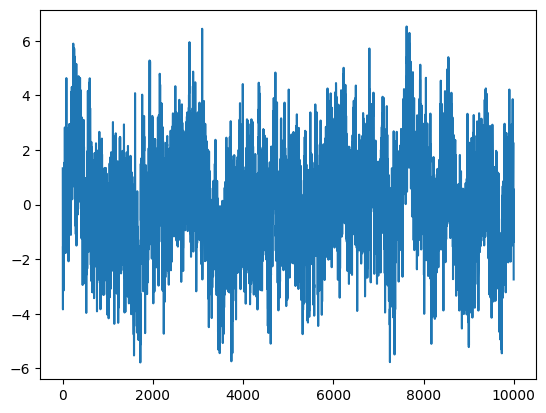

In [151]:
plt.plot(vall)

In [196]:
blc = black_noise(10000)

In [464]:
H, c, data__ = compute_Hc(noise(20000, 0.1))
print(H, c)

0.21678201454125745 2.182589280012572


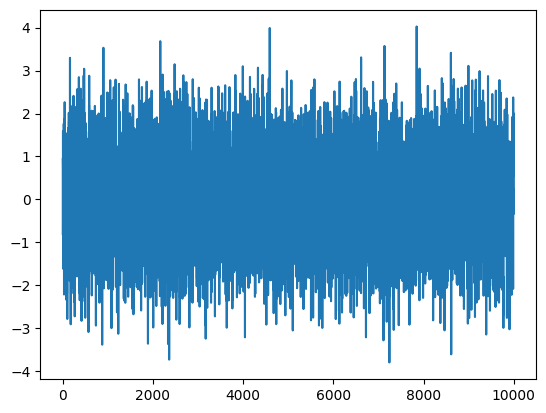

In [197]:
plt.plot(blc)

In [200]:
wth = [np.random.randn() for i in range(10000)]

In [465]:
vec_res = noise(20000, 0.3)

In [466]:
vec_H, vec_c = get_Hc_vectors(vec_res.copy(), 4)

Batch: 4/4: 100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 12.95it/s]


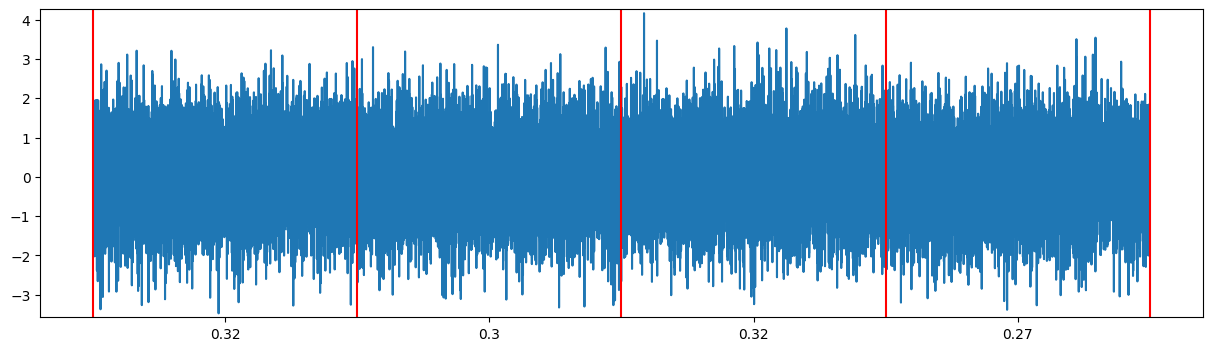

In [467]:
print_H_alalysis(vec_res.copy(), vec_H, 4)

In [468]:
print(sum(vec_H) / len(vec_H))

0.30347657603216366
